In [1]:
from keras.utils import HDF5Matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.utils import to_categorical
from keras import backend as K
import keras.callbacks as cb
from keras.models import load_model
from keras.layers import Input, Dense, BatchNormalization, Dropout, Conv2D, MaxPool2D, Flatten, LeakyReLU, Concatenate, GlobalAveragePooling2D, UpSampling2D
from PIL import Image

import keras
import tensorflow
import tensorflow.compat.v1 as tf

import numpy as np
import pandas as pd
import imageio
import cv2
import pprint
import os
import re
import h5py
import PIL

import src.model as my_model
import src.pcam_loader as data
import src.adaptive_model as am

Using TensorFlow backend.


In [2]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    result = true_positives / (possible_positives + K.epsilon())
    return result


def my_own_preci(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    result = true_positives / (predicted_positives + K.epsilon())
    return result


def f1_score_metrics(y_true, y_pred):
    precision_result = precision(y_true, y_pred)
    recall_result = recall(y_true, y_pred)
    return 2*((precision_result*recall_result)/(precision_result+recall_result+K.epsilon()))


def f1_score_evaluate(precision, recall):
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# config = tf.ConfigProto(device_count={"CPU": 8})
# tensorflow.compat.v1.keras.backend.set_session(tf.Session(config=config))
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1665597165702553224
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4854028697
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7125329522914751291
physical_device_desc: "device: 0, name: GeForce GTX 1660 Ti, pci bus id: 0000:26:00.0, compute capability: 7.5"
]
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1660 Ti, pci bus id: 0000:26:00.0, compute capability: 7.5



In [4]:
def load_dataset(dataset_type, path=None):
    if path:
        dataset_type = os.path.join(path, dataset_type)
    dataset = h5py.File(dataset_type + '_dataset.hdf5', 'r')
    dataset_name = list(dataset)

    y = []
    x = []
    for name in dataset_name:
        data = dataset[name]
        y.append(data.attrs['class_type'])
        x_item = data[:]
        x.append(x_item)

    y = np.array(y)
    y = y.reshape(len(y),1)
    x = np.array(x)
    dataset.close()
    return x, y

x_train, y_train = load_dataset('Train', 'data')
x_test, y_test = load_dataset('Test', 'data')

x_valid_length = round(len(x_test)/2)

x_valid = np.array(x_test[x_valid_length:])
x_test = np.array(x_test[:x_valid_length])

y_valid = y_test[x_valid_length:]
y_test = y_test[:x_valid_length]

In [5]:
batch_size = 10
epochs = 10
num_classes = 2
shape = x_train[0].shape
results = {}

In [6]:
def train(model, x_train, y_train, x_valid, y_valid, model_name):
    callbacks = [
        cb.callbacks.ModelCheckpoint(model_name, save_best_only=True)
    #     cb.callbacks.EarlyStopping(monitor = 'val_loss'),
    #     cb.callbacks.CSVLogger('model.csv', separator=',', append=False),
    #     cb.tensorboard_v1.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')
    ]

    model.compile(loss=keras.losses.categorical_crossentropy, 
                  optimizer=keras.optimizers.Adam(), 
                  metrics=[
                      tensorflow.keras.metrics.Precision(),
                      'accuracy',
                      tensorflow.keras.metrics.Recall(),
                      tensorflow.keras.metrics.TruePositives(),
                      tensorflow.keras.metrics.FalsePositives(),
                      tensorflow.keras.metrics.FalseNegatives()
                          ])

    history = model.fit(
        x_train,
        to_categorical(y_train),
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(x_valid, to_categorical(y_valid)),
        shuffle='batch',
        callbacks=callbacks,
        use_multiprocessing=True, 
        workers=8
    )
    return history

In [7]:
counter = 0
def evaluate(model, x_test, y_test, history, model_name, results, counter):

    test_eval = model.evaluate(x_test, to_categorical(y_test), verbose=0)
    f1_score = f1_score_evaluate(test_eval[2], test_eval[3])
    results[model_name] = {'Test loss:': test_eval[0],
                            'Precision:': test_eval[1],
                            'Accuracy:': test_eval[2],
                            'Recall:': test_eval[3],
                            'TruePositives:': test_eval[4],
                            'FalsePositives:': test_eval[5],
                            'FalseNegatives:': test_eval[6],
                            'F1_score': f1_score}

    import matplotlib.pyplot as plt
    try:            
        graf_value= 'accuracy'
        plt.plot(history.history[graf_value])
        plt.plot(history.history['val_' + graf_value])
        plt.title('val_' + graf_value + ' ' + graf_value)
        plt.ylabel('val_' + graf_value + ', ' + graf_value )
        plt.xlabel('epochs')
        plt.legend(['val_' + graf_value, graf_value], loc='upper left')
        plt.savefig(os.path.join('data', 'giant_training', graf_value + '_' + re.sub('.h5', '.png', model_name)))
        plt.show()
    except:
        print("error")
    try: 
        graf_value= 'precision'
        if counter > 0:
            graf_value += '_' + str(counter)
        plt.plot(history.history[graf_value])
        plt.plot(history.history['val_' + graf_value])
        plt.title('val_' + graf_value + ' ' + graf_value)
        plt.ylabel('val_' + graf_value + ', ' + graf_value )
        plt.xlabel('epochs')
        plt.legend(['val_' + graf_value, graf_value], loc='upper left')
        plt.savefig(os.path.join('data', 'giant_training', graf_value + '_' + re.sub('.h5', '.png', model_name)))
        plt.show()
    except:
        print("error")
    try:
        graf_value= 'recall'
        if counter > 0:
            graf_value += '_' + str(counter)
        plt.plot(history.history[graf_value])
        plt.plot(history.history['val_' + graf_value])
        plt.title('val_' + graf_value + ' ' + graf_value)
        plt.ylabel('val_' + graf_value + ', ' + graf_value )
        plt.xlabel('epochs')
        plt.legend(['val_' + graf_value, graf_value], loc='upper left')
        plt.savefig(os.path.join('data', 'giant_training', graf_value + '_' + re.sub('.h5', '.png', model_name)))
        plt.show()
    except:
        print("error")
    try:
        graf_value= 'true_positives'
        if counter > 0:
            graf_value += '_' + str(counter)
        plt.plot(history.history[graf_value])
        plt.plot(history.history['val_' + graf_value])
        plt.title('val_' + graf_value + ' ' + graf_value)
        plt.ylabel('val_' + graf_value + ', ' + graf_value )
        plt.xlabel('epochs')
        plt.legend(['val_' + graf_value, graf_value], loc='upper left')
        plt.savefig(os.path.join('data', 'giant_training', graf_value + '_' + re.sub('.h5', '.png', model_name)))
        plt.show()
    except:
        print("error")
    try:
        graf_value= 'false_positives'
        if counter > 0:
            graf_value += '_' + str(counter)
        plt.plot(history.history[graf_value])
        plt.plot(history.history['val_' + graf_value])
        plt.title('val_' + graf_value + ' ' + graf_value)
        plt.ylabel('val_' + graf_value + ', ' + graf_value )
        plt.xlabel('epochs')
        plt.legend(['val_' + graf_value, graf_value], loc='upper left')
        plt.savefig(os.path.join('data', 'giant_training', graf_value + '_' + re.sub('.h5', '.png', model_name)))
        plt.show()
    except:
        print("error")
    try:
        graf_value= 'false_negatives'
        if counter > 0:
            graf_value += '_' + str(counter)
        plt.plot(history.history[graf_value])
        plt.plot(history.history['val_' + graf_value])
        plt.title('val_' + graf_value + ' ' + graf_value)
        plt.ylabel('val_' + graf_value + ', ' + graf_value )
        plt.xlabel('epochs')
        plt.legend(['val_' + graf_value, graf_value], loc='upper left')
        plt.savefig(os.path.join('data', 'giant_training', graf_value + '_' + re.sub('.h5', '.png', model_name)))
        plt.show()
    except:
        print("error")
        
    counter += 1

## BackPropagation

Train on 56108 samples, validate on 22646 samples
Epoch 1/10
56108/56108 [==============================] - 134s 2ms/step - loss: 0.2589 - precision: 0.8297 - accuracy: 0.9020 - recall: 0.8297 - true_positives: 24457.1484 - false_positives: 3602.7996 - false_negatives: 3602.7996 - val_loss: 0.3711 - val_precision: 0.8969 - val_accuracy: 0.8697 - val_recall: 0.8969 - val_true_positives: 60466.4570 - val_false_positives: 6971.4556 - val_false_negatives: 6971.4556
Epoch 2/10
56108/56108 [==============================] - 132s 2ms/step - loss: 0.1398 - precision: 0.9072 - accuracy: 0.9541 - recall: 0.9072 - true_positives: 97019.7344 - false_positives: 9794.2256 - false_negatives: 9794.2256 - val_loss: 0.1435 - val_precision: 0.9211 - val_accuracy: 0.9569 - val_recall: 0.9211 - val_true_positives: 134671.6250 - val_false_positives: 11520.2969 - val_false_negatives: 11520.2969
Epoch 3/10
56108/56108 [==============================] - 129s 2ms/step - loss: 0.1156 - precision: 0.9293 - accura

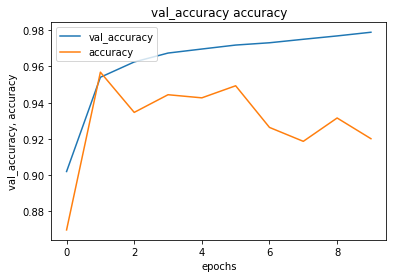

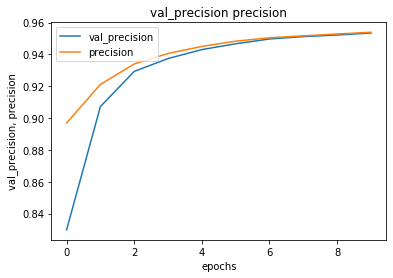

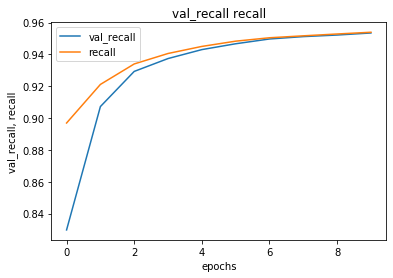

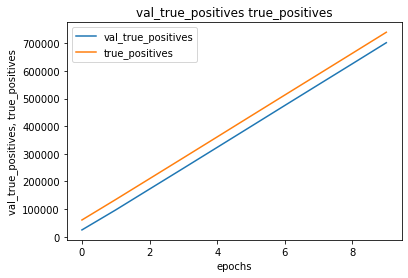

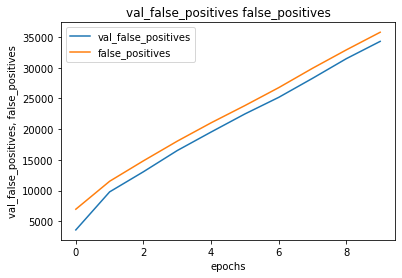

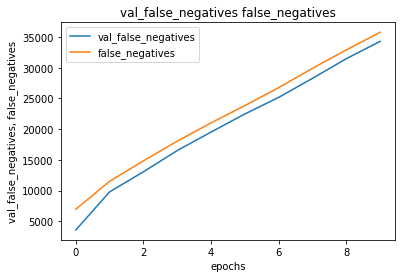

{'adaptive_backpropagation316.h5': {'Accuracy:': 0.914907693862915,
                                    'F1_score': 0.9335073609144824,
                                    'FalseNegatives:': 37645.88671875,
                                    'FalsePositives:': 37645.88671875,
                                    'Precision:': 0.9528790712356567,
                                    'Recall:': 0.9528790712356567,
                                    'Test loss:': 0.3062181306816728,
                                    'TruePositives:': 761238.6875}}


In [8]:
# Input layer with shape of data
input_layer = am.input_layer(shape)
model_name = 'adaptive_backpropagation316.h5'

layers = am.unet_layer(input_layer, 3, 16)

# Use Unet architecture as main model
outputs_layer = am.unet_model(layers)

# Output layer
outputs_layer = am.flatten_layer(outputs_layer)
outputs_layer = am.output_layer(outputs_layer)

# Define model 
model = am.define_model(input_layer, outputs_layer)

history = train(model, x_train, y_train, x_valid, y_valid, model_name)
evaluate(model, x_test, y_test, history, model_name, results, counter)
pprint.pprint(results)

Train on 56108 samples, validate on 22646 samples
Epoch 1/10
56108/56108 [==============================] - 136s 2ms/step - loss: 0.2870 - precision_1: 0.8167 - accuracy: 0.8879 - recall_1: 0.8167 - true_positives_1: 24016.1562 - false_positives_1: 4043.7520 - false_negatives_1: 4043.7520 - val_loss: 0.2854 - val_precision_1: 0.8920 - val_accuracy: 0.9142 - val_recall_1: 0.8920 - val_true_positives_1: 60170.5977 - val_false_positives_1: 7267.3179 - val_false_negatives_1: 7267.3179
Epoch 2/10
56108/56108 [==============================] - 132s 2ms/step - loss: 0.1600 - precision_1: 0.9075 - accuracy: 0.9462 - recall_1: 0.9075 - true_positives_1: 97026.8516 - false_positives_1: 9787.0986 - false_negatives_1: 9787.0986 - val_loss: 0.3095 - val_precision_1: 0.9175 - val_accuracy: 0.9298 - val_recall_1: 0.9175 - val_true_positives_1: 134139.4375 - val_false_positives_1: 12052.4658 - val_false_negatives_1: 12052.4658
Epoch 3/10
56108/56108 [==============================] - 129s 2ms/step - l

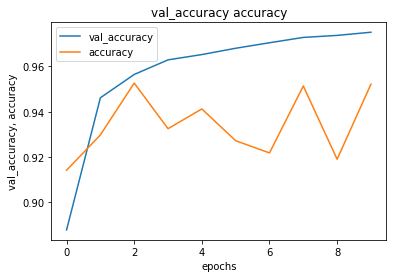

error
error
error
error
error
{'adaptive_backpropagation316.h5': {'Accuracy:': 0.914907693862915,
                                    'F1_score': 0.9335073609144824,
                                    'FalseNegatives:': 37645.88671875,
                                    'FalsePositives:': 37645.88671875,
                                    'Precision:': 0.9528790712356567,
                                    'Recall:': 0.9528790712356567,
                                    'Test loss:': 0.3062181306816728,
                                    'TruePositives:': 761238.6875},
 'adaptive_backpropagation516.h5': {'Accuracy:': 0.9479820132255554,
                                    'F1_score': 0.9494784156390647,
                                    'FalseNegatives:': 39161.30078125,
                                    'FalsePositives:': 39161.30078125,
                                    'Precision:': 0.9509796500205994,
                                    'Recall:': 0.9509796500205994,
 

In [9]:
# Input layer with shape of data
input_layer = am.input_layer(shape)
model_name = 'adaptive_backpropagation516.h5'

layers = am.unet_layer(input_layer, 5, 16)

# Use Unet architecture as main model
outputs_layer = am.unet_model(layers)

# Output layer
outputs_layer = am.flatten_layer(outputs_layer)
outputs_layer = am.output_layer(outputs_layer)

# Define model 
model = am.define_model(input_layer, outputs_layer)

history = train(model, x_train, y_train, x_valid, y_valid, model_name)
evaluate(model, x_test, y_test, history, model_name, results, counter)
pprint.pprint(results)

Train on 56108 samples, validate on 22646 samples
Epoch 1/10
56108/56108 [==============================] - 130s 2ms/step - loss: 0.2690 - precision_2: 0.8336 - accuracy: 0.8961 - recall_2: 0.8336 - true_positives_2: 24377.4219 - false_positives_2: 3682.5308 - false_negatives_2: 3682.5308 - val_loss: 0.2021 - val_precision_2: 0.9034 - val_accuracy: 0.9407 - val_recall_2: 0.9034 - val_true_positives_2: 60943.6836 - val_false_positives_2: 6494.1919 - val_false_negatives_2: 6494.1919
Epoch 2/10
56108/56108 [==============================] - 127s 2ms/step - loss: 0.1518 - precision_2: 0.9186 - accuracy: 0.9495 - recall_2: 0.9186 - true_positives_2: 98192.1406 - false_positives_2: 8621.8916 - false_negatives_2: 8621.8916 - val_loss: 0.1934 - val_precision_2: 0.9269 - val_accuracy: 0.9404 - val_recall_2: 0.9269 - val_true_positives_2: 135503.9375 - val_false_positives_2: 10687.9541 - val_false_negatives_2: 10687.9541
Epoch 3/10
56108/56108 [==============================] - 127s 2ms/step - l

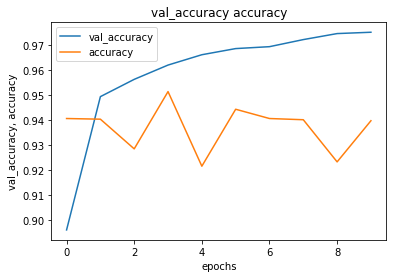

error
error
error
error
error
{'adaptive_backpropagation316.h5': {'Accuracy:': 0.914907693862915,
                                    'F1_score': 0.9335073609144824,
                                    'FalseNegatives:': 37645.88671875,
                                    'FalsePositives:': 37645.88671875,
                                    'Precision:': 0.9528790712356567,
                                    'Recall:': 0.9528790712356567,
                                    'Test loss:': 0.3062181306816728,
                                    'TruePositives:': 761238.6875},
 'adaptive_backpropagation516.h5': {'Accuracy:': 0.9479820132255554,
                                    'F1_score': 0.9494784156390647,
                                    'FalseNegatives:': 39161.30078125,
                                    'FalsePositives:': 39161.30078125,
                                    'Precision:': 0.9509796500205994,
                                    'Recall:': 0.9509796500205994,
 

In [10]:
# Input layer with shape of data
input_layer = am.input_layer(shape)
model_name = 'adaptive_backpropagation716.h5'

layers = am.unet_layer(input_layer, 7, 16)

# Use Unet architecture as main model
outputs_layer = am.unet_model(layers)

# Output layer
outputs_layer = am.flatten_layer(outputs_layer)
outputs_layer = am.output_layer(outputs_layer)

# Define model 
model = am.define_model(input_layer, outputs_layer)

history = train(model, x_train, y_train, x_valid, y_valid, model_name)
evaluate(model, x_test, y_test, history, model_name, results, counter)
pprint.pprint(results)

## Gabor filters

Train on 56108 samples, validate on 22646 samples
Epoch 1/10
56108/56108 [==============================] - 185s 3ms/step - loss: 0.3016 - precision_3: 0.8125 - accuracy: 0.8858 - recall_3: 0.8125 - true_positives_3: 23920.7129 - false_positives_3: 4139.2573 - false_negatives_3: 4139.2573 - val_loss: 0.1854 - val_precision_3: 0.8951 - val_accuracy: 0.9450 - val_recall_3: 0.8951 - val_true_positives_3: 60397.3242 - val_false_positives_3: 7040.5537 - val_false_negatives_3: 7040.5537
Epoch 2/10
56108/56108 [==============================] - 182s 3ms/step - loss: 0.1770 - precision_3: 0.9115 - accuracy: 0.9411 - recall_3: 0.9115 - true_positives_3: 97434.5312 - false_positives_3: 9379.4551 - false_negatives_3: 9379.4551 - val_loss: 0.1708 - val_precision_3: 0.9209 - val_accuracy: 0.9472 - val_recall_3: 0.9209 - val_true_positives_3: 134629.2344 - val_false_positives_3: 11562.6924 - val_false_negatives_3: 11562.6924
Epoch 3/10
56108/56108 [==============================] - 182s 3ms/step - l

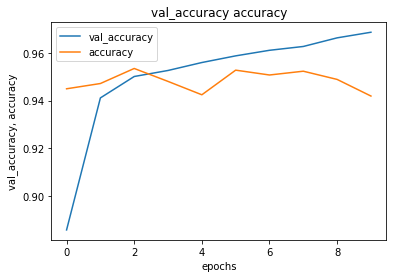

error
error
error
error
error
{'adaptive_backpropagation316.h5': {'Accuracy:': 0.914907693862915,
                                    'F1_score': 0.9335073609144824,
                                    'FalseNegatives:': 37645.88671875,
                                    'FalsePositives:': 37645.88671875,
                                    'Precision:': 0.9528790712356567,
                                    'Recall:': 0.9528790712356567,
                                    'Test loss:': 0.3062181306816728,
                                    'TruePositives:': 761238.6875},
 'adaptive_backpropagation516.h5': {'Accuracy:': 0.9479820132255554,
                                    'F1_score': 0.9494784156390647,
                                    'FalseNegatives:': 39161.30078125,
                                    'FalsePositives:': 39161.30078125,
                                    'Precision:': 0.9509796500205994,
                                    'Recall:': 0.9509796500205994,
 

In [11]:
# Input layer with shape of data
input_layer = am.input_layer(shape)
model_name = 'adaptive_gabor516.h5'

layers = am.gabor_layer(input_layer, 5, 16)

# Use Unet architecture as main model
outputs_layer = am.unet_model(layers)

# Output layer
outputs_layer = am.flatten_layer(outputs_layer)
outputs_layer = am.output_layer(outputs_layer)

# Define model 
model = am.define_model(input_layer, outputs_layer)

# Add filters from gabor function
model.layers[1].set_weights(am.gabor_filter(model))

history = train(model, x_train, y_train, x_valid, y_valid, model_name)
evaluate(model, x_test, y_test, history, model_name, results, counter)
pprint.pprint(results)

Train on 56108 samples, validate on 22646 samples
Epoch 1/10
56108/56108 [==============================] - 185s 3ms/step - loss: 0.3793 - precision_4: 0.7909 - accuracy: 0.8660 - recall_4: 0.7909 - true_positives_4: 23374.0332 - false_positives_4: 4685.9043 - false_negatives_4: 4685.9043 - val_loss: 0.2311 - val_precision_4: 0.8744 - val_accuracy: 0.9215 - val_recall_4: 0.8744 - val_true_positives_4: 58997.4258 - val_false_positives_4: 8440.4746 - val_false_negatives_4: 8440.4746
Epoch 2/10
56108/56108 [==============================] - 182s 3ms/step - loss: 0.2202 - precision_4: 0.8920 - accuracy: 0.9257 - recall_4: 0.8920 - true_positives_4: 95360.9688 - false_positives_4: 11452.9775 - false_negatives_4: 11452.9775 - val_loss: 0.2283 - val_precision_4: 0.9019 - val_accuracy: 0.9247 - val_recall_4: 0.9019 - val_true_positives_4: 131851.3125 - val_false_positives_4: 14340.7266 - val_false_negatives_4: 14340.7266
Epoch 3/10
56108/56108 [==============================] - 182s 3ms/step -

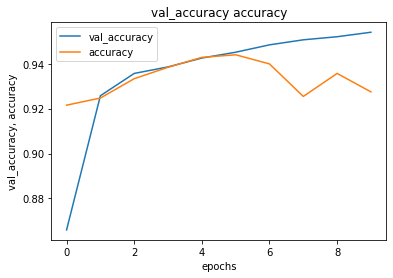

error
error
error
error
error
{'adaptive_backpropagation316.h5': {'Accuracy:': 0.914907693862915,
                                    'F1_score': 0.9335073609144824,
                                    'FalseNegatives:': 37645.88671875,
                                    'FalsePositives:': 37645.88671875,
                                    'Precision:': 0.9528790712356567,
                                    'Recall:': 0.9528790712356567,
                                    'Test loss:': 0.3062181306816728,
                                    'TruePositives:': 761238.6875},
 'adaptive_backpropagation516.h5': {'Accuracy:': 0.9479820132255554,
                                    'F1_score': 0.9494784156390647,
                                    'FalseNegatives:': 39161.30078125,
                                    'FalsePositives:': 39161.30078125,
                                    'Precision:': 0.9509796500205994,
                                    'Recall:': 0.9509796500205994,
 

In [12]:
# Input layer with shape of data
input_layer = am.input_layer(shape)
model_name = 'adaptive_gabor716.h5'

layers = am.gabor_layer(input_layer, 7, 16)

# Use Unet architecture as main model
outputs_layer = am.unet_model(layers)

# Output layer
outputs_layer = am.flatten_layer(outputs_layer)
outputs_layer = am.output_layer(outputs_layer)

# Define model 
model = am.define_model(input_layer, outputs_layer)

# Add filters from gabor function
model.layers[1].set_weights(am.gabor_filter(model))

history = train(model, x_train, y_train, x_valid, y_valid, model_name)
evaluate(model, x_test, y_test, history, model_name, results, counter)
pprint.pprint(results)

Train on 56108 samples, validate on 22646 samples
Epoch 1/10
56108/56108 [==============================] - 187s 3ms/step - loss: 0.3343 - precision_5: 0.8236 - accuracy: 0.8791 - recall_5: 0.8236 - true_positives_5: 24032.9688 - false_positives_5: 4027.0056 - false_negatives_5: 4027.0056 - val_loss: 0.3083 - val_precision_5: 0.8812 - val_accuracy: 0.8921 - val_recall_5: 0.8812 - val_true_positives_5: 59433.2969 - val_false_positives_5: 8004.5757 - val_false_negatives_5: 8004.5757
Epoch 2/10
56108/56108 [==============================] - 185s 3ms/step - loss: 0.2253 - precision_5: 0.8918 - accuracy: 0.9213 - recall_5: 0.8918 - true_positives_5: 95321.1641 - false_positives_5: 11492.8076 - false_negatives_5: 11492.8076 - val_loss: 0.2336 - val_precision_5: 0.9008 - val_accuracy: 0.9260 - val_recall_5: 0.9008 - val_true_positives_5: 131691.5469 - val_false_positives_5: 14500.3916 - val_false_negatives_5: 14500.3916
Epoch 3/10
56108/56108 [==============================] - 185s 3ms/step -

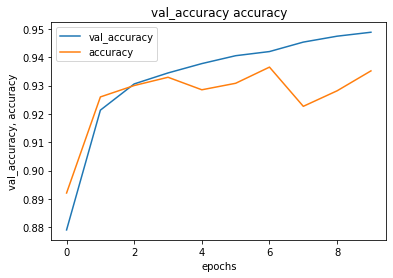

error
error
error
error
error
{'adaptive_backpropagation316.h5': {'Accuracy:': 0.914907693862915,
                                    'F1_score': 0.9335073609144824,
                                    'FalseNegatives:': 37645.88671875,
                                    'FalsePositives:': 37645.88671875,
                                    'Precision:': 0.9528790712356567,
                                    'Recall:': 0.9528790712356567,
                                    'Test loss:': 0.3062181306816728,
                                    'TruePositives:': 761238.6875},
 'adaptive_backpropagation516.h5': {'Accuracy:': 0.9479820132255554,
                                    'F1_score': 0.9494784156390647,
                                    'FalseNegatives:': 39161.30078125,
                                    'FalsePositives:': 39161.30078125,
                                    'Precision:': 0.9509796500205994,
                                    'Recall:': 0.9509796500205994,
 

In [13]:
# Input layer with shape of data
input_layer = am.input_layer(shape)
model_name = 'adaptive_gabor916.h5'

layers = am.gabor_layer(input_layer, 9, 16) 

# Use Unet architecture as main model
outputs_layer = am.unet_model(layers)

# Output layer
outputs_layer = am.flatten_layer(outputs_layer)
outputs_layer = am.output_layer(outputs_layer)

# Define model 
model = am.define_model(input_layer, outputs_layer)

# Add filters from gabor function
model.layers[1].set_weights(am.gabor_filter(model))

history = train(model, x_train, y_train, x_valid, y_valid, model_name)
evaluate(model, x_test, y_test, history, model_name, results, counter)
pprint.pprint(results)

## Autoencoder

Train on 56108 samples, validate on 22646 samples
Epoch 1/10
56108/56108 [==============================] - 216s 4ms/step - loss: 0.2226 - precision_6: 0.8390 - accuracy: 0.9168 - recall_6: 0.8390 - true_positives_6: 24795.7422 - false_positives_6: 3264.1782 - false_negatives_6: 3264.1782 - val_loss: 0.1650 - val_precision_6: 0.9219 - val_accuracy: 0.9494 - val_recall_6: 0.9219 - val_true_positives_6: 62188.2148 - val_false_positives_6: 5249.6338 - val_false_negatives_6: 5249.6338
Epoch 2/10
56108/56108 [==============================] - 212s 4ms/step - loss: 0.1195 - precision_6: 0.9350 - accuracy: 0.9626 - recall_6: 0.9350 - true_positives_6: 99934.9297 - false_positives_6: 6878.9634 - false_negatives_6: 6878.9634 - val_loss: 0.2538 - val_precision_6: 0.9421 - val_accuracy: 0.9527 - val_recall_6: 0.9421 - val_true_positives_6: 137729.8281 - val_false_positives_6: 8462.1719 - val_false_negatives_6: 8462.1719
Epoch 3/10
56108/56108 [==============================] - 212s 4ms/step - los

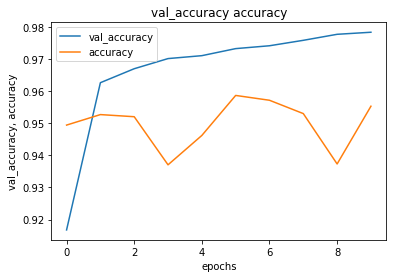

error
error
error
error
error
{'adaptive_autoencoder316.h5': {'Accuracy:': 0.951337993144989,
                                'F1_score': 0.9564711128341571,
                                'FalseNegatives:': 30632.271484375,
                                'FalsePositives:': 30632.271484375,
                                'Precision:': 0.9616600275039673,
                                'Recall:': 0.9616600275039673,
                                'Test loss:': 0.17525145490165747,
                                'TruePositives:': 768251.6875},
 'adaptive_backpropagation316.h5': {'Accuracy:': 0.914907693862915,
                                    'F1_score': 0.9335073609144824,
                                    'FalseNegatives:': 37645.88671875,
                                    'FalsePositives:': 37645.88671875,
                                    'Precision:': 0.9528790712356567,
                                    'Recall:': 0.9528790712356567,
                               

In [14]:
# Input layer with shape of data
input_layer = am.input_layer(shape)
model_name = 'adaptive_autoencoder316.h5'

layers = am.encoder_layer(input_layer, 3, 16)

# Use Unet architecture as main model
outputs_layer = am.unet_model(layers)

# Output layer
outputs_layer = am.flatten_layer(outputs_layer)
outputs_layer = am.output_layer(outputs_layer)

# Define model 
model = am.define_model(input_layer, outputs_layer)

history = train(model, x_train, y_train, x_valid, y_valid, model_name)
evaluate(model, x_test, y_test, history, model_name, results, counter)
pprint.pprint(results)

Train on 56108 samples, validate on 22646 samples
Epoch 1/10
56108/56108 [==============================] - 226s 4ms/step - loss: 0.2716 - precision_7: 0.8178 - accuracy: 0.8989 - recall_7: 0.8178 - true_positives_7: 24204.3848 - false_positives_7: 3855.5693 - false_negatives_7: 3855.5693 - val_loss: 0.2380 - val_precision_7: 0.9020 - val_accuracy: 0.9198 - val_recall_7: 0.9020 - val_true_positives_7: 60837.1797 - val_false_positives_7: 6600.7275 - val_false_negatives_7: 6600.7275
Epoch 2/10
56108/56108 [==============================] - 224s 4ms/step - loss: 0.1359 - precision_7: 0.9172 - accuracy: 0.9574 - recall_7: 0.9172 - true_positives_7: 98067.0469 - false_positives_7: 8746.9229 - false_negatives_7: 8746.9229 - val_loss: 0.1962 - val_precision_7: 0.9279 - val_accuracy: 0.9428 - val_recall_7: 0.9279 - val_true_positives_7: 135656.2344 - val_false_positives_7: 10535.7100 - val_false_negatives_7: 10535.7100
Epoch 3/10
56108/56108 [==============================] - 224s 4ms/step - l

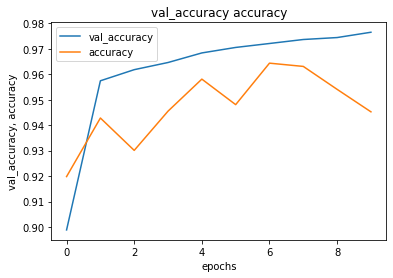

error
error
error
error
error
{'adaptive_autoencoder316.h5': {'Accuracy:': 0.951337993144989,
                                'F1_score': 0.9564711128341571,
                                'FalseNegatives:': 30632.271484375,
                                'FalsePositives:': 30632.271484375,
                                'Precision:': 0.9616600275039673,
                                'Recall:': 0.9616600275039673,
                                'Test loss:': 0.17525145490165747,
                                'TruePositives:': 768251.6875},
 'adaptive_autoencoder516.h5': {'Accuracy:': 0.941667377948761,
                                'F1_score': 0.9494437443467428,
                                'FalseNegatives:': 34072.23046875,
                                'FalsePositives:': 34072.23046875,
                                'Precision:': 0.9573497176170349,
                                'Recall:': 0.9573497176170349,
                                'Test loss:': 0.1970348

In [15]:
# Input layer with shape of data
input_layer = am.input_layer(shape)
model_name = 'adaptive_autoencoder516.h5'

layers = am.encoder_layer(input_layer, 5, 16) 

# Use Unet architecture as main model
outputs_layer = am.unet_model(layers)

# Output layer
outputs_layer = am.flatten_layer(outputs_layer)
outputs_layer = am.output_layer(outputs_layer)

# Define model 
model = am.define_model(input_layer, outputs_layer)

history = train(model, x_train, y_train, x_valid, y_valid, model_name)
evaluate(model, x_test, y_test, history, model_name, results, counter)
pprint.pprint(results)

Train on 56108 samples, validate on 22646 samples
Epoch 1/10
56108/56108 [==============================] - 236s 4ms/step - loss: 0.3738 - precision_8: 0.7710 - accuracy: 0.8628 - recall_8: 0.7710 - true_positives_8: 22902.0098 - false_positives_8: 5157.9092 - false_negatives_8: 5157.9092 - val_loss: 0.2417 - val_precision_8: 0.8748 - val_accuracy: 0.9389 - val_recall_8: 0.8748 - val_true_positives_8: 59033.9570 - val_false_positives_8: 8403.9219 - val_false_negatives_8: 8403.9219
Epoch 2/10
56108/56108 [==============================] - 231s 4ms/step - loss: 0.1700 - precision_8: 0.8985 - accuracy: 0.9459 - recall_8: 0.8985 - true_positives_8: 96092.3594 - false_positives_8: 10721.6221 - false_negatives_8: 10721.6221 - val_loss: 0.2464 - val_precision_8: 0.9137 - val_accuracy: 0.9579 - val_recall_8: 0.9137 - val_true_positives_8: 133595.3594 - val_false_positives_8: 12596.5117 - val_false_negatives_8: 12596.5117
Epoch 3/10
56108/56108 [==============================] - 231s 4ms/step -

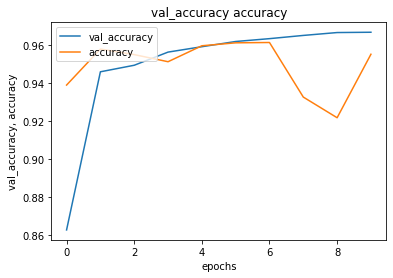

error
error
error
error
error


In [16]:
# Input layer with shape of data
input_layer = am.input_layer(shape)
model_name = 'adaptive_autoencoder716.h5'

layers = am.encoder_layer(input_layer, 7, 16) 

# Use Unet architecture as main model
outputs_layer = am.unet_model(layers)

# Output layer
outputs_layer = am.flatten_layer(outputs_layer)
outputs_layer = am.output_layer(outputs_layer)

# Define model 
model = am.define_model(input_layer, outputs_layer)

history = train(model, x_train, y_train, x_valid, y_valid, model_name)
evaluate(model, x_test, y_test, history, model_name, results, counter)

In [17]:
pprint.pprint(results)

{'adaptive_autoencoder316.h5': {'Accuracy:': 0.951337993144989,
                                'F1_score': 0.9564711128341571,
                                'FalseNegatives:': 30632.271484375,
                                'FalsePositives:': 30632.271484375,
                                'Precision:': 0.9616600275039673,
                                'Recall:': 0.9616600275039673,
                                'Test loss:': 0.17525145490165747,
                                'TruePositives:': 768251.6875},
 'adaptive_autoencoder516.h5': {'Accuracy:': 0.941667377948761,
                                'F1_score': 0.9494437443467428,
                                'FalseNegatives:': 34072.23046875,
                                'FalsePositives:': 34072.23046875,
                                'Precision:': 0.9573497176170349,
                                'Recall:': 0.9573497176170349,
                                'Test loss:': 0.1970348203674825,
                   